In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [4]:
class BearingBasedControllerWithLeaders:
    def __init__(self, num_agents, leaders, k_p, k_v, neighbors, g_star, leader_velocities, init_pos):
        """
        Initialize the controller with leaders and followers.
        
        Parameters:
            num_agents (int): Number of agents.
            leaders (list): Indices of leader agents.
            k_p (float): Proportional gain.
            k_v (float): Velocity gain.
            neighbors (dict): Dictionary of neighbors for each agent {i: [j1, j2, ...]}.
            g_star (dict): Desired bearings { (i, j): g_ij_star }.
            leader_velocities (dict): Dictionary of constant velocities for leaders {i: velocity}.
        """
        self.num_agents = num_agents
        self.leaders = leaders
        self.k_p = k_p
        self.k_v = k_v
        self.neighbors = neighbors
        self.g_star = g_star
        self.leader_velocities = leader_velocities
        self.positions = init_pos  # Initialize positions randomly
        self.velocities = np.zeros((num_agents, 2))          # Initialize velocities as zero

    def compute_bearings(self):
        """Compute the current bearings."""
        g = {}
        for i in range(self.num_agents):
            for j in self.neighbors[i]:
                diff = self.positions[j] - self.positions[i]
                g[(i, j)] = diff / np.linalg.norm(diff)
        return g
    
    def compute_bearing_rates(self, g, dt):
        """Compute the rates of change of bearings."""
        g_dot = {}
        for (i, j), g_ij in g.items():
            velocity_diff = self.velocities[j] - self.velocities[i]
            g_dot[(i, j)] = (velocity_diff - np.dot(velocity_diff, g_ij) * g_ij) / np.linalg.norm(g_ij)
        return g_dot
    
    def update(self, dt):
        """
        Update the positions and velocities of agents.
        
        Parameters:
            dt (float): Time step for integration.
        """
        g = self.compute_bearings()
        g_dot = self.compute_bearing_rates(g, dt)
        
        accelerations = np.zeros((self.num_agents, 2))
        
        for i in range(self.num_agents):
            if i in self.leaders:
                # Leaders move with constant velocity
                self.velocities[i] = self.leader_velocities[i]
            else:
                # Followers use the control law
                sum_g = np.zeros(2)
                sum_g_dot = np.zeros(2)
                
                for j in self.neighbors[i]:
                    g_ij = g[(i, j)]
                    g_star_ij = self.g_star[(i, j)]
                    g_dot_ij = g_dot[(i, j)]
                    
                    sum_g += g_ij - g_star_ij
                    sum_g_dot += g_dot_ij
                
                accelerations[i] = self.k_p * sum_g + self.k_v * sum_g_dot
        
        # Update velocities and positions for followers
        for i in range(self.num_agents):
            if i not in self.leaders:
                self.velocities[i] += accelerations[i] * dt
            self.positions[i] += self.velocities[i] * dt
    
    def get_positions(self):
        """Return the current positions of agents."""
        return self.positions


In [5]:
def plot_formation(positions, neighbors):
    """
    Plot agent positions and edges between neighbors.

    Parameters:
        positions (dict): Dictionary containing the positions of agents {i: [x, y]}.
        neighbors (dict): Dictionary of neighbors for each agent {i: [j1, j2, ...]}.
    """
    # Create a new plot
    plt.figure(figsize=(8, 8))
    
    # Plot agents
    for i, pos in positions.items():
        plt.scatter(pos[0], pos[1], label=f"Agent {i}", s=100, color='red')  # Agent position
        plt.text(pos[0] + 0.05, pos[1] + 0.05, f"{i}", fontsize=12, color='blue')  # Label agent
        
    # Plot edges
    for i, neighbor_list in neighbors.items():
        for j in neighbor_list:
            # Draw a line between agent i and agent j
            pos_i = positions[i]
            pos_j = positions[j]
            plt.plot([pos_i[0], pos_j[0]], [pos_i[1], pos_j[1]], 'k-', alpha=0.4)  # Edge between agents
    
    # Plot settings
    plt.title("Agent Formation")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.axis('equal')
    plt.grid(True)
    #plt.legend()
    plt.show()
    return



def compute_g_star(positions, neighbors):
    """
    Compute the desired bearings g_star for a formation.

    Parameters:
        positions (dict): Dictionary containing the positions of agents {i: [x, y]}.
        neighbors (dict): Dictionary of neighbors for each agent {i: [j1, j2, ...]}.

    Returns:
        dict: Desired bearings { (i, j): g_ij_star }.
    """
    g_star = {}

    for i, neighbor_list in neighbors.items():
        for j in neighbor_list:
            # Compute the relative position
            diff = np.array(positions[j]) - np.array(positions[i])
            
            # Normalize to obtain the bearing vector
            g_star[(i, j)] = diff / np.linalg.norm(diff)
    
    return g_star

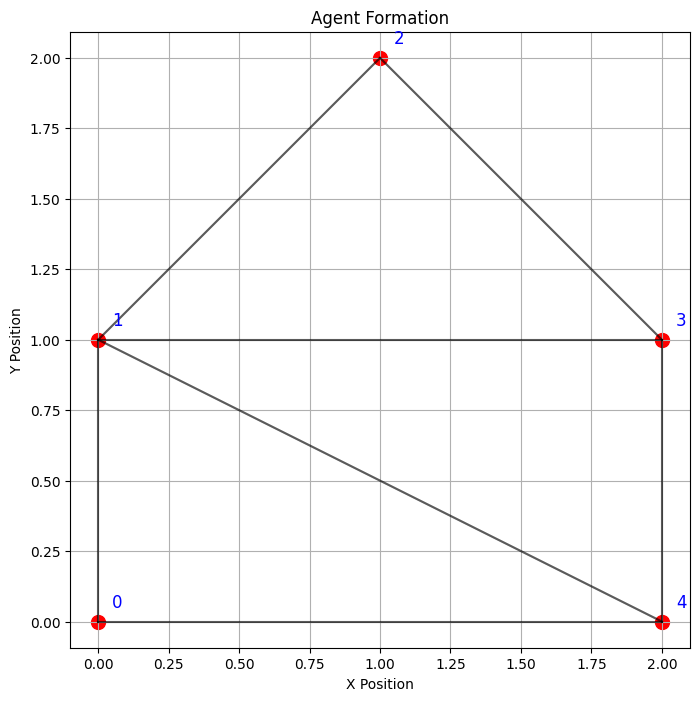

In [14]:

# Example Usage

num_agents = 5
leaders = [0, 1]  # Agents 0 and 1 are leaders
leader_velocities = {0: np.array([0.1, 0.1]), 1: np.array([0.1, 0.1])}
k_p = 1.0
k_v = 0.5
neighbors = {
    0: [1, 4],
    1: [0, 2, 3, 4],
    2: [1, 3],
    3: [1, 2, 4],
    4: [0, 1, 3]
}
positions = {
    0: [0.0, 0.0],
    1: [0.0, 1.0],
    2: [1.0, 2.0],
    3: [2.0, 1.0],
    4: [2.0, 0.0]
}
plot_formation(positions, neighbors)
g_star = compute_g_star(positions, neighbors)


In [30]:
init_pos = np.array([
    [0.0, 0.0], 
    [0.0, 1.0], 
    [-1.1, 2.1], 
    [2.2, 1.5], 
    [2.5, 0.6]])

In [31]:
controller = BearingBasedControllerWithLeaders(num_agents, leaders, k_p, k_v, neighbors, g_star, leader_velocities, init_pos)
dt = 0.01
num_steps = 5000
positions_history = []

# Run simulation
for _ in range(num_steps):
    controller.update(dt)
    positions_history.append(controller.get_positions().copy())

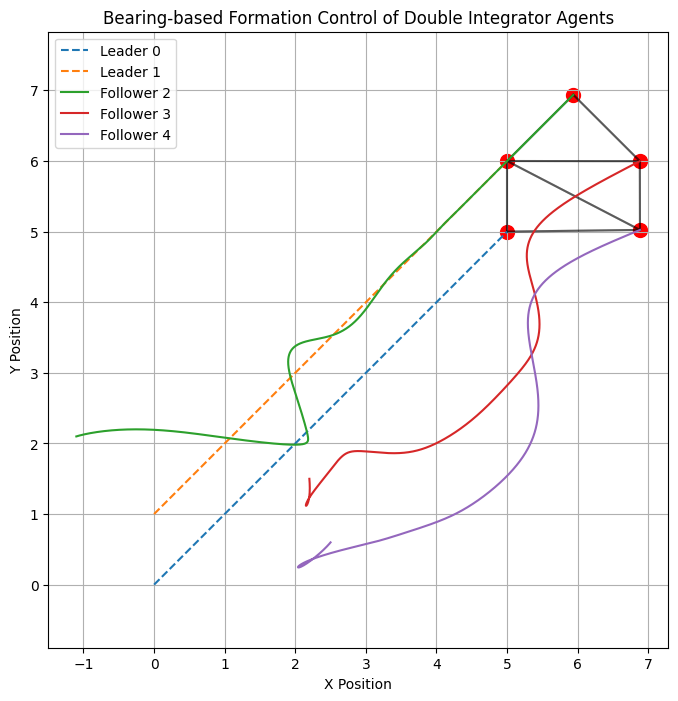

In [38]:

positions_history = np.array(positions_history)

# Plotting
plt.figure(figsize=(8, 8))
for i, neighbor_list in neighbors.items():
        for j in neighbor_list:
            pos_i = positions_history[-1, i]
            pos_j = positions_history[-1, j]
            plt.plot([pos_i[0], pos_j[0]], [pos_i[1], pos_j[1]], 'k-', alpha=0.4)
for i in range(num_agents):
    if i in leaders:
        # Leaders are plotted with dashed lines
        plt.plot(positions_history[:, i, 0], positions_history[:, i, 1], '--', label=f"Leader {i}")
    else:
        # Followers are plotted with solid lines
        plt.plot(positions_history[:, i, 0], positions_history[:, i, 1], label=f"Follower {i}")
    plt.scatter(positions_history[-1, i, 0], positions_history[-1, i, 1],c='red', s=100)  # Final positions
    # Plot edges corresponding to neighbors at the final position
    
plt.title("Bearing-based Formation Control of Double Integrator Agents")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.savefig("double_integrator.svg")
plt.show()

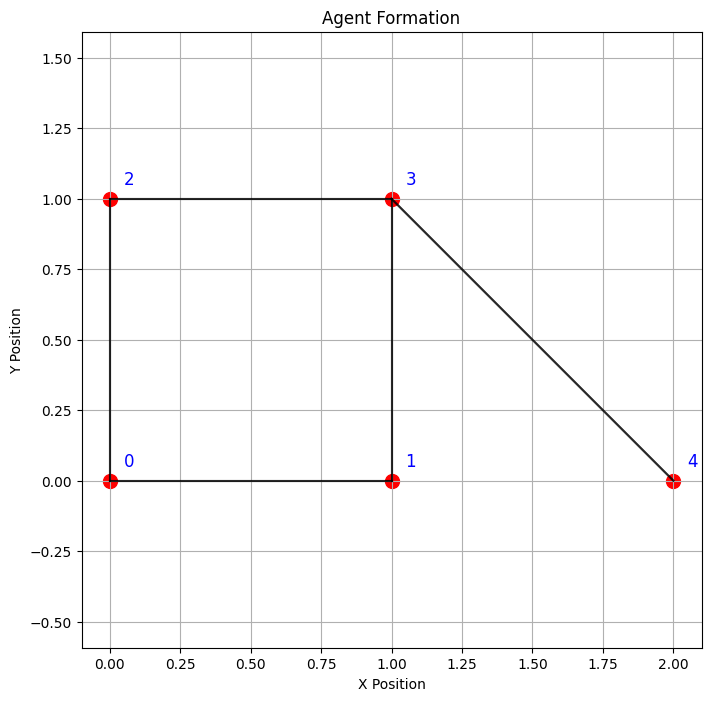

{(0, 1): array([1., 0.]),
 (0, 2): array([0., 1.]),
 (1, 0): array([-1.,  0.]),
 (1, 3): array([0., 1.]),
 (2, 0): array([ 0., -1.]),
 (2, 3): array([1., 0.]),
 (3, 1): array([ 0., -1.]),
 (3, 2): array([-1.,  0.]),
 (3, 4): array([ 0.70710678, -0.70710678]),
 (4, 3): array([-0.70710678,  0.70710678])}

In [7]:

# Example positions of agents


# Example neighbors of each agent
neighbors = {
    0: [1, 2],
    1: [0, 3],
    2: [0, 3],
    3: [1, 2, 4],
    4: [3],
}

# Plot the formation

g_star